In [34]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from tqdm import tqdm
from ryu_tool import mytool

In [2]:
# 필요한 파일을 불러옵니다
price = pd.read_pickle("Data/allstock_reduced.pickle")
spx_mask = pd.read_pickle("Data/spx_mask.pickle")

rtn = price.pct_change(fill_method=None)

In [3]:
# 목적함수 Define
def obj_minvariance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

In [4]:
start_idx = pd.date_range("2006","2023", freq="YS")
end_idx = pd.date_range("2006","2023", freq="Y")

len(start_idx), len(end_idx)

(18, 17)

In [5]:
start_idx[0], end_idx[0]

(Timestamp('2006-01-01 00:00:00'), Timestamp('2006-12-31 00:00:00'))

In [31]:
len(start_idx)

17

In [60]:
pf_value = 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
weight_dict = {}
pf_rtn = {}

start_idx = pd.date_range("2007","2023", freq="QS")[:-1]
end_idx = pd.date_range("2007","2023", freq="Q")

for i in tqdm(range(len(start_idx))):
    if i + 1 == len(start_idx): #마지막날은 weight계산할 필요가 없음...
        break
    
    # start~end의 주가를 보고 포폴 구성
    start = start_idx[i].strftime("%Y-%m")
    end = end_idx[i].strftime("%Y-%m")
    
    mask_sample = spx_mask.loc[end].iloc[-1]
    universe = mask_sample.loc[~mask_sample.isna()].index # S&P500 구성종목을 가져옵니다
    rtn_sample = rtn.loc[start:end, universe]
    cov_matrix = rtn_sample.cov()
    
    bounds = tuple((0.001,1) for _ in range(len(rtn_sample.columns))) # 제약조건 setting
    initial_weights = np.ones(len(rtn_sample.columns)) / len(rtn_sample.columns)
    
    result = minimize(obj_minvariance, 
                      initial_weights, 
                      args=(cov_matrix,),
                      method='SLSQP', 
                      constraints=constraints, 
                      bounds=bounds)
    
    min_variance_weights = result.x
    weight_dict[end] = min_variance_weights
    dollar_value = min_variance_weights * pf_value # 포트폴리오로 담을 각 주식의 달러가치
    # weight 계산한 당일 종가로 포트폴리오를 construct한다고 가정
    
    # 포트폴리오 성과 측정 기간
    
    start_date, end_date = start_idx[i+1].strftime("%Y-%m"), end_idx[i+1].strftime("%Y-%m")
    rtn_sample2 = rtn.loc[start_date:end_date, universe]
    
    for date in rtn_sample2.index:
        if date > rtn.index[-1]:
            break
        dollar_value = dollar_value * (1+rtn_sample2.loc[date]) # dollar value 변화를 update
        pf_value = dollar_value.sum()
        pf_rtn[date.strftime("%Y-%m-%d")] = pf_value

  9%|▉         | 6/64 [00:17<03:26,  3.55s/it]

In [58]:
rt = pd.Series(pf_rtn)
rt["2008-01-02"] = 1
r = rt.sort_index().pct_change().fillna(0)
r.index = pd.to_datetime(r.index)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


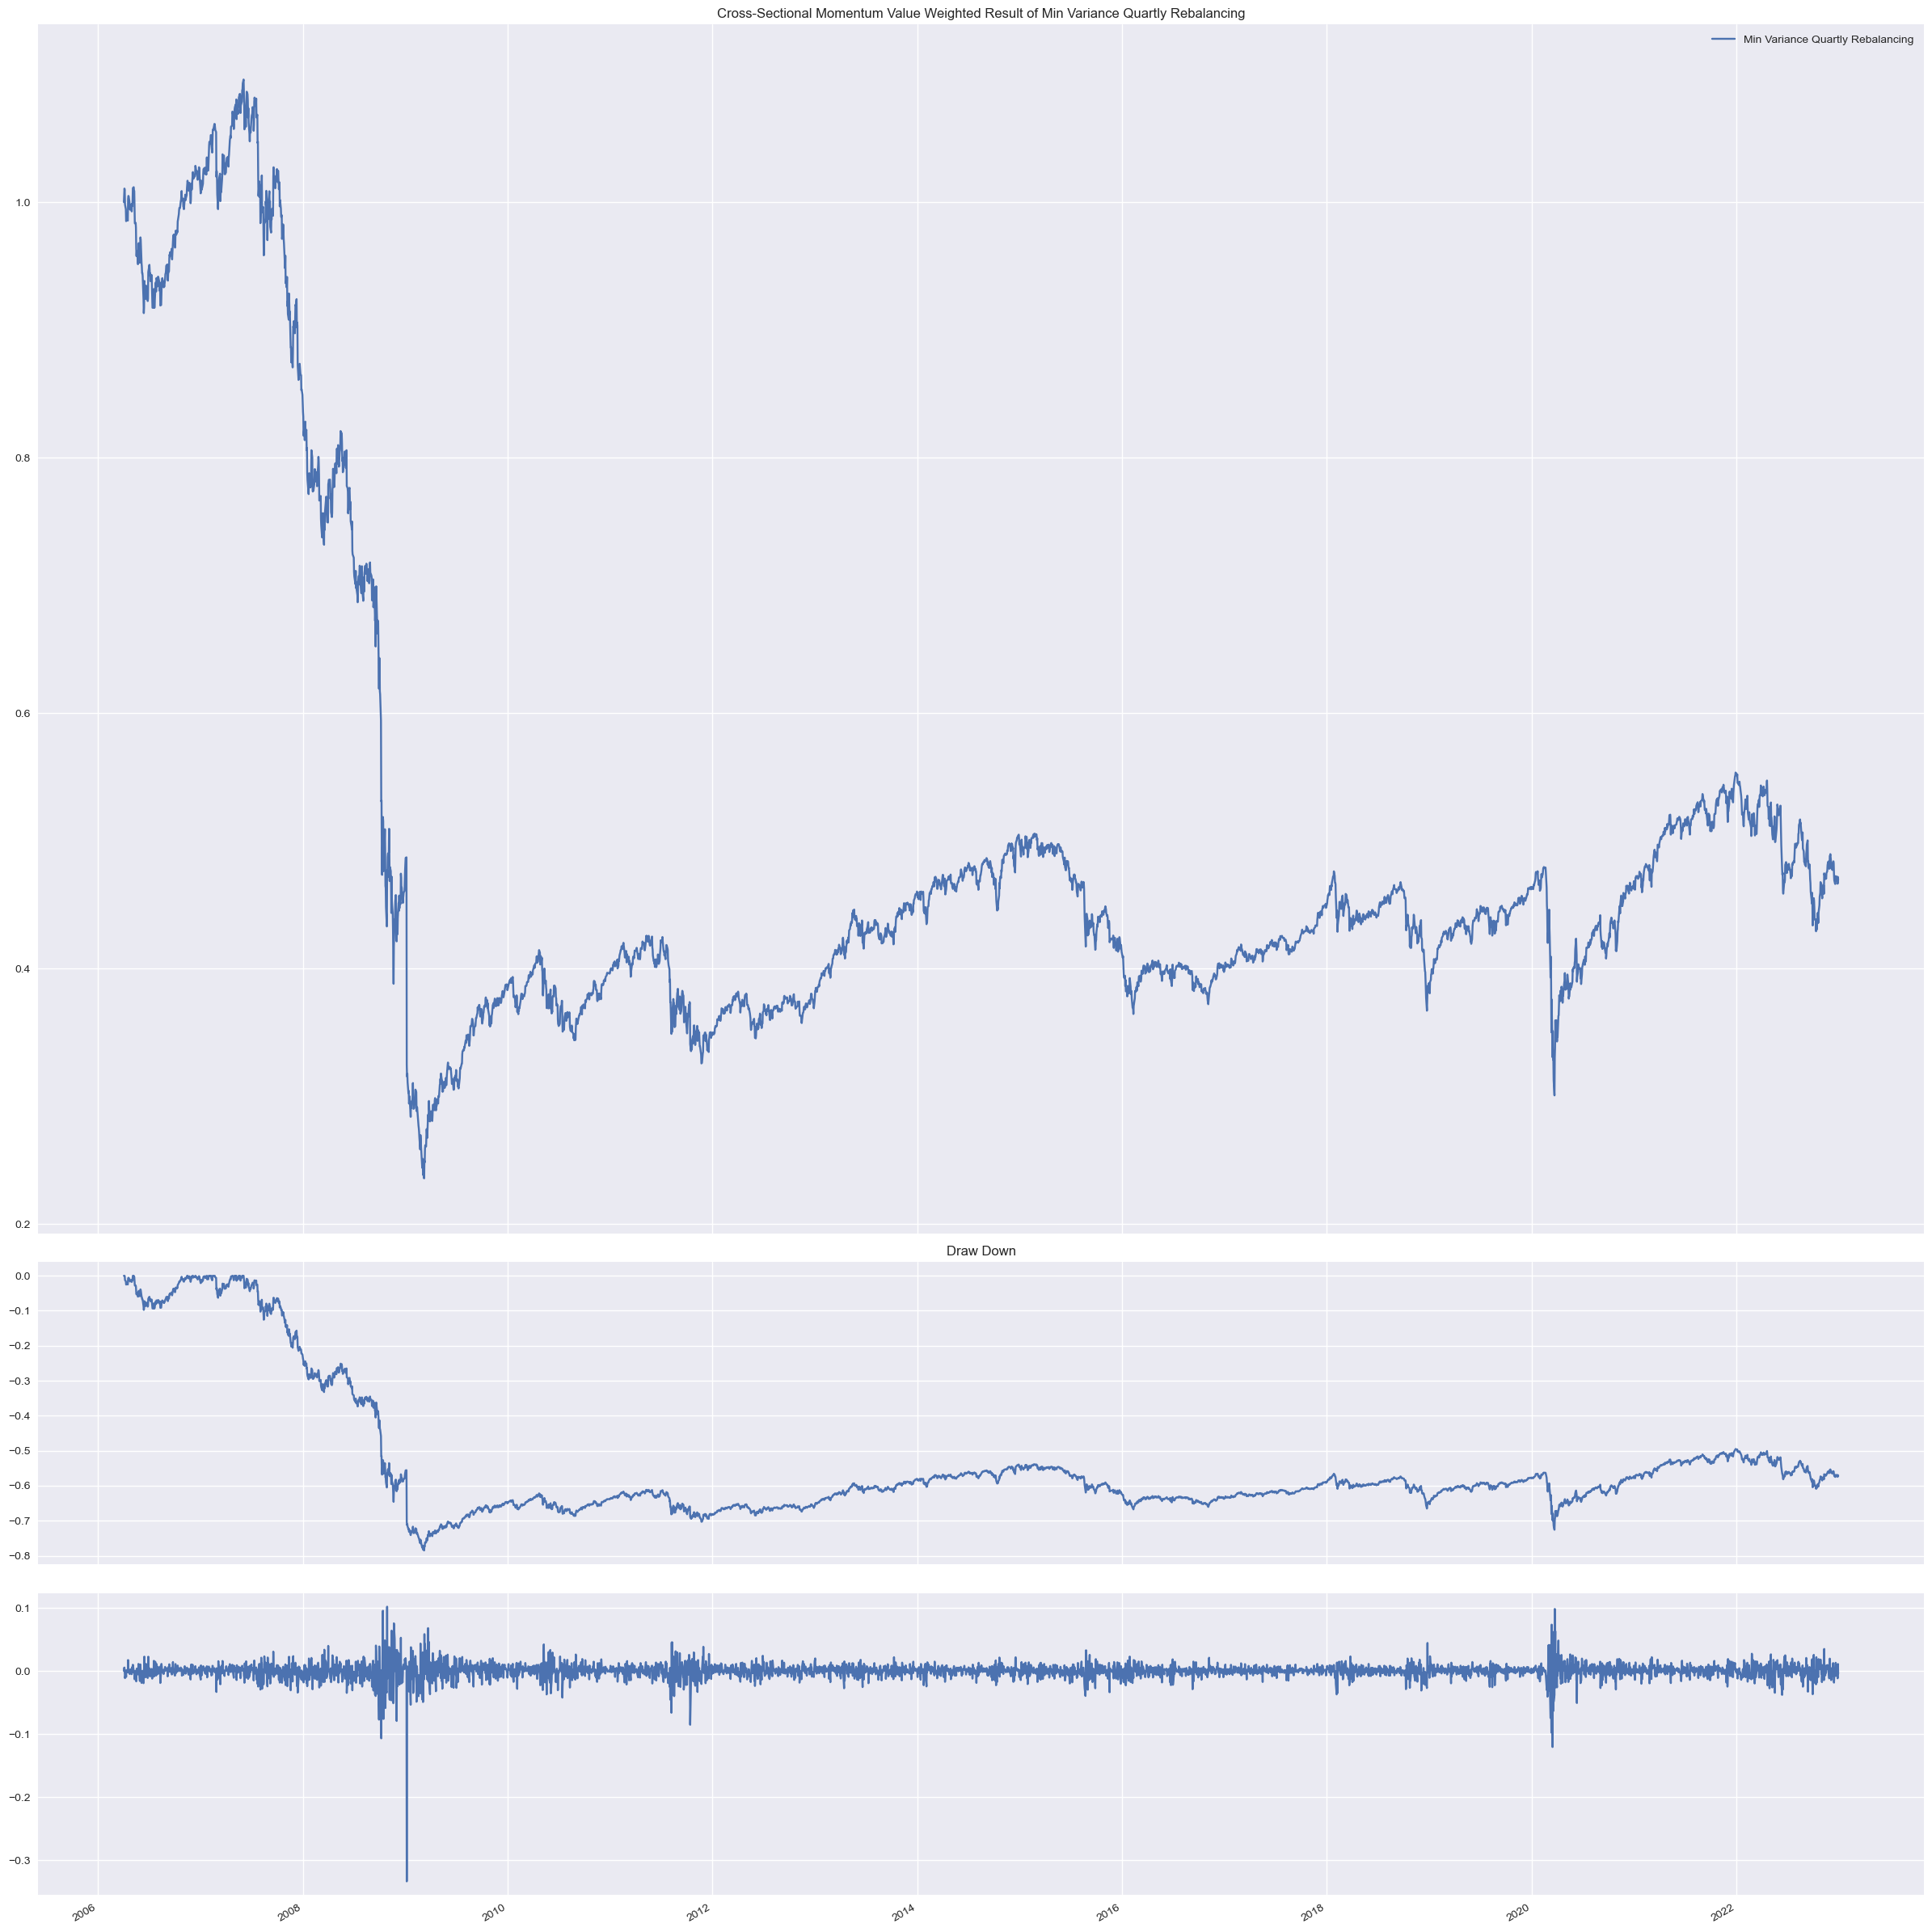

In [59]:
mytool.draw_return_result({"Min Variance Quartly Rebalancing" :r})